<h1>Проект для «Викишоп» с BERT

<h2>Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

<h2>Цель проекта

- Обучить модель классифицировать комментарии на позитивные и негативные

- Построить модель со значением метрики качества *F1* не меньше 0.75

<h2>Описание данных

В нашем распоряжении набор данных с разметкой о токсичности правок.

Данные находятся в файле `toxic_comments.csv`.

- Столбец `text` - содержит текст комментария

- Столбец `toxic` — целевой признак

<h2>План проекта

1. [Загрузка и обзор данных](#1)

2. [Обучение](#2)

3. [Выводы](#3)

<a id='1'></a>

<h2>Загрузка и обзор анных

Импортируем необходимые библиотеки для работы. Считаем данные из csv-файла в переменную `df` и изучим их.

Путь к файлу: `/datasets/toxic_comments.csv`.

Для обучения модели будем использовать `gpu`(графический процессор).

Для работы выберем модель `DistilBERT` из-за её относительной легковесности по сравнению с полным `BERT`. Это позволит сократить время обучения без существенной потери в производительности. Сохраним её название в `MODEL_NAME`.

In [ ]:
!pip install optuna

In [ ]:
!/opt/conda/bin/python -m pip install wordcloud 

In [1]:
# Стандартные библиотеки
import os
import re
import string

# Сторонние библиотеки
import nltk
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer

import torch
import optuna
import transformers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from wordcloud import WordCloud
from tqdm.notebook import tqdm
from datasets import Dataset
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          TrainingArguments,
                          Trainer,
                          DataCollatorWithPadding)

# Устанавливаем SEED для воспроизводимости результатов
SEED = 12345
np.random.seed(SEED)
torch.manual_seed(SEED)

# Мы выбрали DistilBERT, так как это легковесная версия BERT,
# что позволяет быстрее обучать модель, потребляя меньше ресурсов
MODEL_NAME = "distilbert-base-uncased"

In [2]:
# Проверка наличия доступного GPU
print(torch.cuda.is_available())

True


In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
os.environ["WANDB_DISABLED"] = "true"

In [4]:
# Пути к данным
path_1 = 'C:/jupyter projects/16 sprint/toxic_comments.csv'
path_2 = '/datasets/toxic_comments.csv'
path_3 = '/content/toxic_comments.csv'

# Загрузка данных из CSV файла
if os.path.exists(path_1):
    df = pd.read_csv(path_1, index_col=0)
elif os.path.exists(path_2):
    df = pd.read_csv(path_2, index_col=0)
elif os.path.exists(path_3):
    df = pd.read_csv(path_3, index_col=0)
else:
    print('Error')

Размерность датасета: (159292, 2)




,text,toxic
109583,Expert Categorizers \n\nWhy is there no menti...,0
105077,"""\n\n Noise \n\nfart* talk. """,1
82244,"An indefinite block is appropriate, even for a...",0
18740,I don't understand why we have a screenshot of...,0
128310,"Hello! Some of the people, places or things yo...",0
108406,"""::::::::::::::If you read carefully, my comme...",1
25283,"""\nDid you make it at WP:AE? ofShalott """,0
32695,know as much as he thinks.,0
31936,Thank you for your comment and willingness to ...,0
20244,UPDATE 3-12-06\n\nHEY YALL IM GOING TO BE GONE...,0


<Axes: title={'center': 'Распределение целевого признака'}>

0    0.898388
1    0.101612
Name: toxic, dtype: float64

Text(0.5, 1.0, 'Распределение целевого признака')

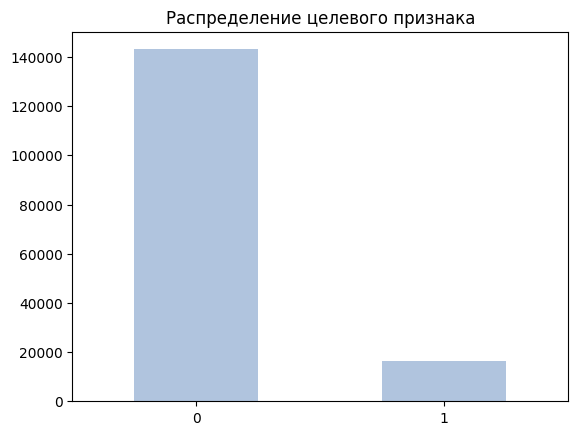

In [5]:
print(f'Размерность датасета: {df.shape}\n\n')
display(df.sample(10),
        df['toxic'].value_counts().plot(kind='bar',
                                        color='lightsteelblue',
                                        rot=0),
        df['toxic'].value_counts(normalize=True),
        plt.title('Распределение целевого признака'))

<h3>Вывод

В данном блоке мы:

- Импортировали библиотеки и модули для работы, установили константы
- Проверили наличие `gpu` и передали его в переменную `device`
- Импортировали данные в переменную `df`
- Узнали что в датасете 159292 наблюдений
- Увидели что в целевой переменной присутствует дисбаланс классов

<h2>Разведочный анализ данных

Проведем небольшой анализ данных - изучим токсичные и нетоксичные твиты, чтобы получить лучшее представление о часто встречающихся словах в каждой из категорий.

Для этого проведем обработку твитов и составим облако слов.

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
# Делим тексты на позитивные и негативные
text_pos = list(df.query('toxic == 0')['text'])
text_neg = list(df.query('toxic ==1')['text'])

In [8]:
# Словарь эмоджи
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused', '<(-_-)>': 'robot',
          ":')": 'sadsmile', ';)': 'wink', ';-)': 'wink', '(:-D': 'gossip', '=^.^=': 'cat'}

# Список стоп-слов
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'wa' 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', 'shes', 'should', 'shouldve','so', 'some', 'such',
             't', 'than', 'that', 'thatll', 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which', 'while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', 'youd', 'youll', "youre",
             'youve', 'your', 'yours', 'yourself', 'yourselves']

def preprocess(textdata):
    processedText = []

    # Создаем лемматизатор и стеммер
    wordLemm = WordNetLemmatizer()

    # Регулярные выражения
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        # Заменяем все URls на 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Заменяем эмоджи
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI"+emojis[emoji])
        # Заменяем @USERNAME на 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)
        # Заменяем все не буквенно-цифровые знаки
        tweet = re.sub(alphaPattern, " ", tweet)
        # Заменяем 3 или более буквы подряд на 2 буквы
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Проверяем слово на наличие в стоп-листе
            if len(word)>1:
                # Лемматизируем слово
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')

        processedText.append(tweetwords)

    return processedText

In [9]:
# Применяем функцию для очистки текста
positive = preprocess(text_pos)
negative = preprocess(text_neg)

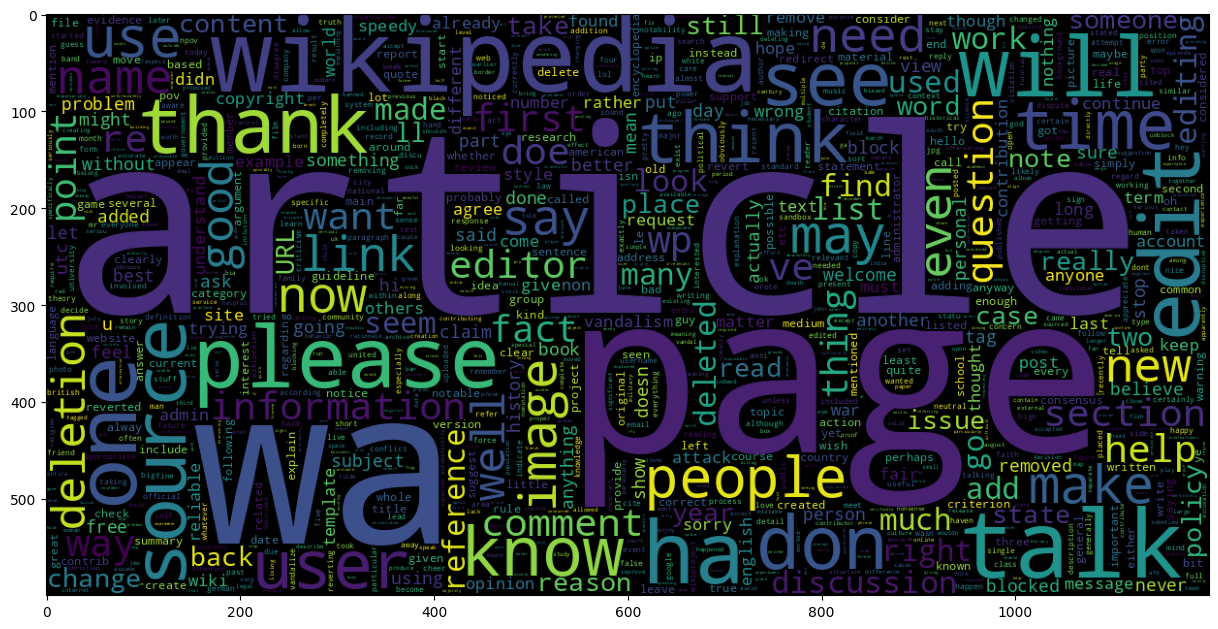

In [10]:
plt.figure(figsize=(15,15))
wc = WordCloud(max_words=1000, width=1200, height=600,
               collocations=False).generate(" ".join(positive))
plt.imshow(wc)

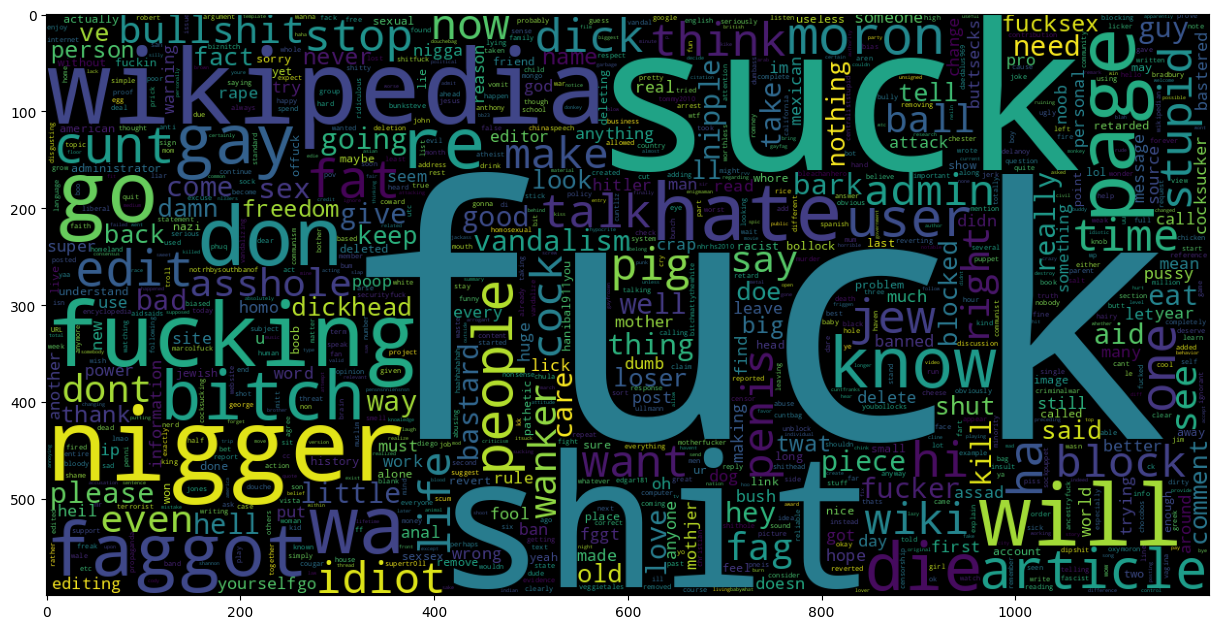

In [11]:
data_neg = negative
plt.figure(figsize=(15,15))
wc = WordCloud(max_words=1000, width=1200, height=600,
               collocations=False).generate(" ".join(negative))
plt.imshow(wc)

<h3>Вывод

Мы провели небольшой анализ данных и выяснили, что в твитах, отмеченных как токсичные, пользователи чаще используют оскорбления и ругательства. В нетоксичных твитах же видно частое употребление таких слов как `article`, `wikipedia`, `page` и др.

<a id='2'></a>

<h2>Обучение

<h3>Предобработка данных

Так как мы имеем дело с большим датасетом, возьмем для работы подвыборку из 20 000 наблюдений - это делается для ускорения экспериментов, иначе модель будет проводить обучение более 4-х часов.

Сохраним эти наблюдения в новую переменную `df_sample` и будем работать с ней, чтобы не изменять глобальную переменную. Столбец `toxic` переименуем в `label`, так как это более общепринятое обозначение для меток в задачах классификации.

In [12]:
# Берем подвыборку данных для ускорения эксперимента
df_sample, _ = train_test_split(df, train_size=20000, stratify=df['toxic'], random_state=SEED)
# Переименование столбца
df_sample.rename(columns={'toxic' : 'label'}, inplace=True)

Проверим распределение классов в целевой переменной.

<Axes: >

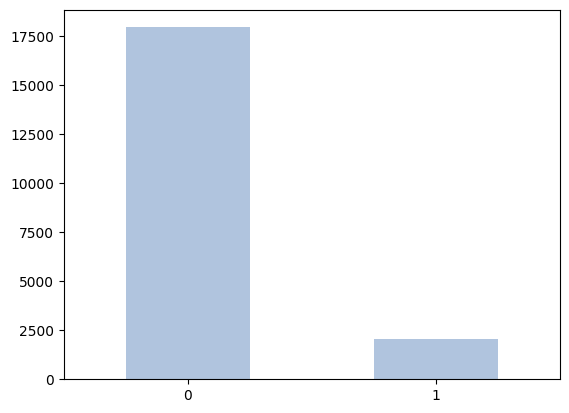

In [13]:
# Проверим распределение
df_sample['label'].value_counts().plot(kind='bar',
                                       color='lightsteelblue',
                                       rot=0)

In [14]:
df_sample['label'].value_counts(normalize=True)

0    0.8984
1    0.1016
Name: label, dtype: float64

Дисбаланс в подвыборке сохранен.



---


<h3>Distilbert-base-uncased



Вычислим веса для классов с помощью функции `compute_class_weight` из `sklearn.utils.class_weight`. Эта функция позволяет автоматически вычислить веса для классов на основе их дисбаланса.

In [15]:
# Вычисляем веса классов
weights = compute_class_weight('balanced', classes=[0,1], y=df_sample['label'])
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

Данные разделим на обучающую и тестовую выборки, чтобы модель могла быть обучена на одном наборе данных и проверена на другом, что позволит оценить её реальную производительность.

In [16]:
# Подготовка данных для обучения
train, test = train_test_split(df_sample, test_size=0.2, random_state=SEED)
dataset_train = Dataset.from_pandas(train)
dataset_test = Dataset.from_pandas(test)

Токенизация — это процесс преобразования текста в последовательность числовых значений, которые могут быть поданы на вход модели. `DistilBERT`, как и другие модели из семейства `BERT`, требует специфической токенизации.

Применим функцию предобработки, чтобы ограничить длину входных данных и применить нужное заполнение (`padding`).

In [17]:
# Токенизация данных для DistilBERT
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_function(sample):  # функция для предобработки данных
    return tokenizer(sample["text"], truncation=True, padding='max_length', max_length=512)

tokenized_train = dataset_train.map(preprocess_function, batched=True)
tokenized_test = dataset_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

`Data collator` помогает объединять разные партии данных в один батч. Это важно для эффективного обучения на графическом процессоре, так как обработка нескольких примеров за один раз может существенно ускорить обучение.

In [18]:
# Создание data collator
data_collacator = DataCollatorWithPadding(tokenizer=tokenizer)

Создадим модель для классификации последовательностей. Это делается с помощью метода `from_pretrained`, который загружает предварительно обученную модель `MODEL_NAME` и адаптирует ее для задачи классификации с двумя классами (`num_labels=2`)

Создадим функцию потерь `CrossEntropyLoss` и передадим веса классов в нее с помощью аргумента `weight`. Это означает, что при вычислении потерь для каждого примера, вес ошибки будет умножаться на соответствующий вес класса.

Таким образом модель будет "наказываться" сильнее за ошибки на классе с меньшим количеством примеров и "меньше наказываться" за ошибки на классе с большим количеством примеров.

In [19]:
# Инициализация модели
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)

# Передаем веса классов в функцию потерь
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Создадим подкласс `CustomTrainer` от основного класса `Trainer` библиотеки `Transformers`. Этот подкласс переопределяет метод `compute_loss`, чтобы использовать свою функцию потерь.

In [20]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs["labels"]
        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

Функция `compute_metrics` вычисляет метрику F1 для прогнозов и реальных меток.

In [21]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds)
    return {
        'f1': f1,
    }

Зададим определенные параметры для тренировки.

In [22]:
training_args = TrainingArguments(
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    output_dir='./results'
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Создадим экземпляр `CustomTrainer` с указанными аргументами и данными. Вызовем метод `train()`, чтобы начать процесс обучения.

In [23]:
# Используем CustomTrainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    compute_metrics=compute_metrics,
    eval_dataset=tokenized_test,
    data_collator=data_collacator,
    tokenizer=tokenizer
)

trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,0.155900,0.266907,0.813778
2,0.790100,0.373592,0.807135
3,0.000500,0.591760,0.817967


TrainOutput(global_step=8001, training_loss=0.2498340108681901, metrics={'train_runtime': 2709.6431, 'train_samples_per_second': 17.715, 'train_steps_per_second': 2.953, 'total_flos': 6358435135488000.0, 'train_loss': 0.2498340108681901, 'epoch': 3.0})

Выведем значение лучшего `f1`.

In [24]:
# Оценка модели на тестовой выборке
results = trainer.evaluate()

# Получение f1 score из результатов
f1_test = results['eval_f1']
print(f"f1 score на тестовой выборке: {f1_test:.4f}")

f1 score на тестовой выборке: 0.8180


<h2>Классические модели на эмбеддингах

Попробуем использовать `Distilbert` чтобы получить эмбеддинги и передать их в модели CatBoost, RandomForest, LGBM и LogisticRegression.

Подберем гиперпараметры для моделей с помощью `optuna`, оценим их качество на кросс-валидации и выберем лучшую из них для оценки на тестовой выборке.

In [25]:
# Используем предобученный токенизатор DistilBERT
tokenizer = transformers.DistilBertTokenizer.from_pretrained(MODEL_NAME)

tokenized = df_sample['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [26]:
# Используем предобученную модель DistilBERT
model = transformers.DistilBertModel.from_pretrained(MODEL_NAME).to(device)

batch_size = 200
embeddings = []
for i in tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
features = np.concatenate(embeddings)

In [28]:
X = features
y = df_sample['label']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

In [29]:
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['CatBoost',
                                                               'RandomForest',
                                                               'LGBM',
                                                               'LogisticRegression'])

    if classifier_name == 'CatBoost':
        cat_iterations = trial.suggest_int('iterations', 200, 600)
        cat_depth = trial.suggest_int('depth', 2, 12)
        cat_learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)


        classifier = CatBoostClassifier(iterations=cat_iterations,
                                        depth=cat_depth,
                                        learning_rate=cat_learning_rate,
                                        verbose=False,
                                        random_state=SEED)

    elif classifier_name == 'RandomForest':
        rf_n_estimators = trial.suggest_int('n_estimators', 100, 600)
        rf_max_depth = trial.suggest_int('max_depth', 2, 12)
        rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

        classifier = RandomForestClassifier(n_estimators=rf_n_estimators,
                                            max_depth=rf_max_depth,
                                            min_samples_split=rf_min_samples_split,
                                            min_samples_leaf=rf_min_samples_leaf,
                                            random_state=SEED)

    elif classifier_name == 'LGBM':
        lgbm_n_estimators = trial.suggest_int('n_estimators', 100, 600)
        lgbm_max_depth = trial.suggest_int('max_depth', 2, 12)
        lgbm_learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)

        classifier = LGBMClassifier(n_estimators=lgbm_n_estimators,
                                    max_depth=lgbm_max_depth,
                                    learning_rate=lgbm_learning_rate,
                                    random_state=SEED)

    else:
        log_penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
        log_C = trial.suggest_float('C', 1e-2, 10, log=True)

        classifier = LogisticRegression(penalty=log_penalty,
                                        C=log_C, 
                                        max_iter=1000,
                                        solver='saga', 
                                        random_state=SEED)

    return cross_val_score(classifier, X, y, cv=3, scoring='f1_macro').mean()

In [30]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

[I 2023-09-12 19:47:43,540] A new study created in memory with name: no-name-f929a052-7274-447a-8813-55cfc9863565
[I 2023-09-12 19:54:23,836] Trial 0 finished with value: 0.8130687755444423 and parameters: {'classifier': 'CatBoost', 'iterations': 570, 'depth': 6, 'learning_rate': 0.08886764447233265}. Best is trial 0 with value: 0.8130687755444423.
[I 2023-09-12 19:55:20,140] Trial 1 finished with value: 0.807724980101777 and parameters: {'classifier': 'CatBoost', 'iterations': 236, 'depth': 3, 'learning_rate': 0.05854320372560666}. Best is trial 0 with value: 0.8130687755444423.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_s

In [31]:
print("Лучшие гиперпараметры: ", study.best_trial.params)
print("Лучший результат f1-score: ", study.best_value)

Лучшие гиперпараметры:  {'classifier': 'LogisticRegression', 'penalty': 'l2', 'C': 2.3750793312580494}
Лучший результат f1-score:  0.8389606125913289


In [35]:
model = LogisticRegression(penalty='l2', C=2.3750793312580494, max_iter=1000, random_state=SEED)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(f'f1-score у LogisticRegression: {f1_score(y_test, predictions)}')

f1-score у LogisticRegression: 0.7105590062111801


<h3>Вывод

Мы обучили модель `distilbert-base-uncased` и классические модели CatBoost, RandomForest, LGBM и LogisticRegression.

В итоге лучший результат показала Distilbert, выдав `f1 score = 0.818`. Из классических моделей лучше всего себя показала `LogisticRegression` с `f1 score = 0.71`.

<a id='3'></a>

<h2>Выводы

В данном проекте мы:

- Загрузили и изучили исходные данные
- Провели обработку данных
- Обучили модель `distilbert-base-uncased` с кастомной функцией потерь, так как был дисбаланс классов в целевом признаке; обучили модели классического машинного обучения на эмбеддингах
- Сделали предсказания и оценили их метрикой `F1 score`

Цель проекта достигнута, так как мы обучили модель `distilbert-base-uncased` классифицировать твиты на позитивные и негативные и добились значения метрики качества F1 в 0.818.